Raccolta dei dati dall'API


In [165]:
import requests
import pandas
from datetime import datetime, timedelta

# Funzione per raccogliere dati meteorologici storici
def get_weather_data(api_key, location, start_date, end_date):
    url = f"http://api.openweathermap.org/data/2.5/onecall/timemachine"
    data = []
    current_date = start_date

    # Itera attraverso le date richieste
    while current_date <= end_date:
        timestamp = int(current_date.timestamp()) 
        # Richiede dati per la data corrente
        response = requests.get(f"{url}?lat={location[0]}&lon={location[1]}&dt={timestamp}&appid={api_key}")
        if response.status_code == 200:
            data.append(response.json())
        current_date += timedelta(days=1)
    return data

print("ciao")

# Parametri per la richiesta API
api_key = "your_api_key"  # Inserisci la tua chiave API
location = (40.7128, -74.0060)  # Latitudine e longitudine per New York
start_date = datetime(2023, 6, 1)  # Data di inizio per la raccolta dati, anno, mese e giorno
end_date = datetime(2023, 6, 7)  # Data di fine per la raccolta dati

# Raccolta dei dati
raw_data = get_weather_data(api_key, location, start_date, end_date)


ciao


In [166]:
import pandas as pd

# Funzione per convertire i dati JSON raccolti in un DataFrame
def parse_weather_data(raw_data):
    parsed_data = []
    for day_data in raw_data:
        for hour_data in day_data['hourly']:
            parsed_data.append({
                'timestamp': datetime.fromtimestamp(hour_data['dt']),
                'temperature': hour_data['temp'],
                'humidity': hour_data['humidity'],
                'pressure': hour_data['pressure']
            })
    return pd.DataFrame(parsed_data)

# Parsing dei dati raccolti
df = parse_weather_data(raw_data)

print(df.head())


Empty DataFrame
Columns: []
Index: []


In [167]:
import pandas as pd

# Carica il file CSV
df = pd.read_csv('weather_data.csv')

# Mostra il contenuto
print(df)


Empty DataFrame
Columns: [timestamp, temperature, humidity, pressure]
Index: []


Visualizzazione dei dati

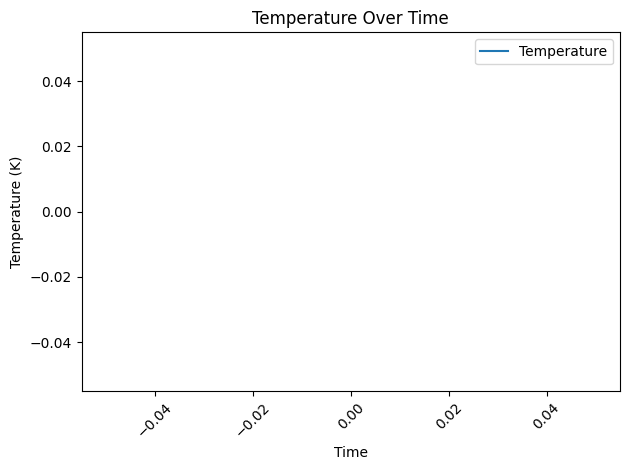

In [168]:
import matplotlib.pyplot as plt

# Grafico della temperatura nel tempo
plt.plot(df['timestamp'], df['temperature'], label='Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Temperature Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [169]:
import requests
import json
import csv
from datetime import datetime, timedelta

# Funzione per raccogliere dati meteorologici storici
def get_weather_data(api_key, location, start_date, end_date):
    url = "http://api.openweathermap.org/data/2.5/onecall/timemachine"
    data = []
    current_date = start_date

    # Itera attraverso le date richieste
    while current_date <= end_date:
        timestamp = int(current_date.timestamp())
        # Richiede dati per la data corrente
        response = requests.get(f"{url}?lat={location[0]}&lon={location[1]}&dt={timestamp}&appid={api_key}")
        if response.status_code == 200:
            data.append(response.json())
        current_date += timedelta(days=1)
    
    return data

# Funzione per salvare i dati raccolti in un file CSV
def save_to_csv(data, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['timestamp', 'temperature', 'humidity', 'pressure']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for day_data in data:
            for hour_data in day_data['hourly']:
                writer.writerow({
                    'timestamp': datetime.fromtimestamp(hour_data['dt']).strftime('%Y-%m-%d %H:%M:%S'),
                    'temperature': hour_data['temp'],
                    'humidity': hour_data['humidity'],
                    'pressure': hour_data['pressure']
                })

# Parametri per la richiesta API
api_key = "your_api_key"  # Inserisci la tua chiave API
location = (40.7128, -74.0060)  # Latitudine e longitudine per New York
start_date = datetime(2023, 6, 1)  # Data di inizio per la raccolta dati
end_date = datetime(2023, 6, 7)  # Data di fine per la raccolta dati

# Raccolta dei dati
raw_data = get_weather_data(api_key, location, start_date, end_date)

# Salvataggio dei dati in un file CSV
save_to_csv(raw_data, 'weather_data.csv')

print("I dati sono stati salvati in weather_data.csv")


I dati sono stati salvati in weather_data.csv


raccolta e analisi  degli eventi in base alla variabile e al dispositivo e per determinare quali variabili hanno generato più eventi su tutto l'asso temporale


Analisi degli eventi per tipo di device

In [173]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

try:
    # Esegui la query e ottieni i risultati
    with connection.cursor() as cursor:
        query = """
        SELECT dm.id_device_type,
               dm.model AS device_model,
               de.variable,
               COUNT(de.id) AS event_count,
               GROUP_CONCAT(DISTINCT de.event_string SEPARATOR ', ') AS event_details
        FROM device_events de
        JOIN devices d ON de.id_device = d.id
        JOIN device_models dm ON d.id_device_model = dm.ID
        GROUP BY dm.id_device_type, dm.model, de.variable
        ORDER BY dm.id_device_type, event_count DESC;
        """
        cursor.execute(query)
        result = cursor.fetchall()

        # Converti i risultati in DataFrame pandas
        columns = ['id_device_type', 'device_model', 'variable', 'event_count', 'event_details']
        df = pd.DataFrame(result, columns=columns)

        # Salva i dati in file CSV distinti per tipo di dispositivo
        for device_type, group_df in df.groupby('id_device_type'):
            output_csv_path = f'results_device_type_{device_type}.csv'
            group_df.to_csv(output_csv_path, index=False)
            print(f"Dati salvati in {output_csv_path}")

        # Analizza i dati e crea un messaggio riassuntivo
        summary = df.groupby(['device_model', 'variable']).agg({'event_count': 'sum', 'event_details': 'first'}).reset_index()
        summary_message = summary.groupby('device_model').apply(
            lambda x: f"Dispositivo '{x['device_model'].iloc[0]}': "
                      f"la variabile più comune è '{x['variable'].iloc[0]}' con {x['event_count'].iloc[0]} eventi. "
                      f"Dettagli eventi: {x['event_details'].iloc[0]}."
        ).tolist()

        for message in summary_message:
            print(message)

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Dati salvati in results_device_type_1.csv
Dati salvati in results_device_type_16.csv
Dati salvati in results_device_type_19.csv
Dati salvati in results_device_type_27.csv
Dispositivo 'Indium': la variabile più comune è 'environmentalTemp' con 10 eventi. Dettagli eventi: test temp  maggiore di 0, test temp amb  superiore a 21.
Dispositivo 'MainFrame MFR1 RTX': la variabile più comune è 'slot4-PowerRx' con 1 eventi. Dettagli eventi: None.
Dispositivo 'QBT': la variabile più comune è 'forwardPower' con 20 eventi. Dettagli eventi: Power low 500W.
Dispositivo 'RX 2 GHz': la variabile più comune è 'fieldLevel' con 1 eventi. Dettagli eventi: Basso valore campo ricevuto.
Dispositivo 'Tiger E3': la variabile più comune è 'aCpuTemperature' con 1 eventi. Dettagli eventi: test CPU temp  maggiore 30.


/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_739/830902977.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_message = summary.groupby('device_model').apply(


Estraiamo tutte le variabili che hanno la sottostringa "temp"

In [174]:
import pymysql
import pandas as pd
import json
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

try:
    # Esegui la query e ottieni i risultati
    with connection.cursor() as cursor:
        query = """
        SELECT d.id AS device_id,
               d.name AS device_name,
               dv.id AS var_id,
               dv.name AS var_name,
               dv.description AS var_description
        FROM devices d
        JOIN device_vars dv ON d.id = dv.id_device
        WHERE dv.name LIKE '%temp%'
        ORDER BY d.id, dv.name;
        """
        cursor.execute(query)
        result = cursor.fetchall()

        # Converti i risultati in DataFrame pandas
        columns = ['device_id', 'device_name', 'var_id', 'var_name', 'var_description']
        df = pd.DataFrame(result, columns=columns)

        # Salva i dati in un file CSV
        output_csv_path = 'temp_variables_by_device.csv'
        df.to_csv(output_csv_path, index=False)

        # Organizza i dati in un dizionario
        temp_vars_dict = df.groupby('device_id').apply(
            lambda x: x[['var_id', 'var_name', 'var_description']].to_dict('records')
        ).to_dict()

        # Salva il dizionario in un file JSON
        output_json_path = 'temp_variables_by_device.json'
        with open(output_json_path, 'w') as json_file:
            json.dump(temp_vars_dict, json_file, indent=4)

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()

print(f"I risultati sono stati salvati in {output_csv_path} e {output_json_path}.")


I risultati sono stati salvati in temp_variables_by_device.csv e temp_variables_by_device.json.


/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_739/718907162.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_vars_dict = df.groupby('device_id').apply(


Andiamo a guardare il voltaggio

In [175]:
import pymysql
import pandas as pd
import os
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

try:
    # Esegui la query e ottieni i risultati
    with connection.cursor() as cursor:
        query = """
        SELECT d.id AS device_id,
               d.name AS device_name,
               dv.id AS var_id,
               dv.name AS var_name,
               dv.description AS var_description
        FROM devices d
        JOIN device_vars dv ON d.id = dv.id_device
        WHERE dv.name LIKE '%temp%' 
           OR dv.name LIKE '%volt%' 
           OR dv.name LIKE '%current%' 
           OR dv.name LIKE '%state%' 
           OR dv.name LIKE '%efficiency%' 
           OR dv.name LIKE '%power%' 
           OR dv.name LIKE '%flow%' 
           OR dv.name LIKE '%time%' 
           OR dv.name LIKE '%pressure%' 
           OR dv.name LIKE '%noise%' 
           OR dv.name LIKE '%air%'
        ORDER BY d.id, dv.name;
        """
        cursor.execute(query)
        result = cursor.fetchall()

        # Converti i risultati in DataFrame pandas
        columns = ['device_id', 'device_name', 'var_id', 'var_name', 'var_description']
        df = pd.DataFrame(result, columns=columns)

        # Filtra e salva in file CSV separati
        substrings = ['temp', 'volt', 'current', 'state', 'efficiency', 'power', 'flow', 'time', 'pressure', 'noise', 'air']
        for substring in substrings:
            filtered_df = df[df['var_name'].str.contains(substring, case=False, na=False)]
            if not filtered_df.empty:
                output_csv_path = f'relevant_variables_{substring}.csv'
                filtered_df.to_csv(output_csv_path, index=False)
                print(f"Salvato: {output_csv_path}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()

print("Tutti i file CSV sono stati creati.")


Salvato: relevant_variables_temp.csv
Salvato: relevant_variables_volt.csv
Salvato: relevant_variables_current.csv
Salvato: relevant_variables_state.csv
Salvato: relevant_variables_efficiency.csv
Salvato: relevant_variables_power.csv
Salvato: relevant_variables_time.csv
Salvato: relevant_variables_pressure.csv
Salvato: relevant_variables_noise.csv
Salvato: relevant_variables_air.csv
Tutti i file CSV sono stati creati.


Andiamo arggruupare tutte le variabili che hanno al loro interno la parola "temp" e andiamo a selezionare tutti gli eventi basati su quel dizionario dai diversi dispositivi

In [176]:

import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

try:
    # Esegui la query e ottieni i risultati
    with connection.cursor() as cursor:
        query = """
        SELECT d.id AS device_id,
               d.name AS device_name,
               de.variable,
               COUNT(*) AS event_count
        FROM devices d
        JOIN device_events de ON d.id = de.id_device
        WHERE de.variable LIKE '%temp%'
        GROUP BY d.id, de.variable
        ORDER BY d.id, event_count DESC;
        """
        cursor.execute(query)
        result = cursor.fetchall()

        # Converti i risultati in DataFrame pandas
        columns = ['device_id', 'device_name', 'variable', 'event_count']
        df = pd.DataFrame(result, columns=columns)

        # Raggruppa i dati in un dizionario
        event_dict = {}
        for _, row in df.iterrows():
            device_id = row['device_id']
            variable = row['variable']
            event_count = row['event_count']
            if device_id not in event_dict:
                event_dict[device_id] = {}
            if variable not in event_dict[device_id]:
                event_dict[device_id][variable] = event_count

        # Stampa il dizionario per controllo
        print("Dizionario degli eventi per variabili che contengono 'temp':")
        print(event_dict)

        # Salva il dizionario in un file JSON per ulteriori analisi
        import json
        output_json_path = 'temp_events_by_device.json'
        with open(output_json_path, 'w') as json_file:
            json.dump(event_dict, json_file, indent=4)

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()

    print(f"Tutti i dati sono stati salvati in {output_json_path}.")

Dizionario degli eventi per variabili che contengono 'temp':
{631: {'environmentalTemp': 10}, 632: {'aCpuTemperature': 1}}
Tutti i dati sono stati salvati in temp_events_by_device.json.


Andiamo a vedere per tutte le sottostringhe, i vari eventi

In [177]:
import pymysql
import pandas as pd
import json
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

# Lista delle sottostringhe da cercare
substrings = ['temp', 'volt', 'current', 'state', 'efficiency', 'power', 'flow', 'uptime', 'pressure', 'noise', 'air']

# Dizionario per salvare tutti i risultati
all_results = {}

try:
    with connection.cursor() as cursor:
        for substring in substrings:
            query = f"""
            SELECT d.id AS device_id,
                   d.name AS device_name,
                   de.variable,
                   COUNT(*) AS event_count
            FROM devices d
            JOIN device_events de ON d.id = de.id_device
            WHERE de.variable LIKE '%{substring}%'
            GROUP BY d.id, de.variable
            ORDER BY d.id, event_count DESC;
            """
            cursor.execute(query)
            result = cursor.fetchall()

            # Converti i risultati in DataFrame pandas
            columns = ['device_id', 'device_name', 'variable', 'event_count']
            df = pd.DataFrame(result, columns=columns)

            # Aggiungi i risultati al dizionario
            for _, row in df.iterrows():
                device_id = row['device_id']
                variable = row['variable']
                event_count = row['event_count']
                if substring not in all_results:
                    all_results[substring] = {}
                if device_id not in all_results[substring]:
                    all_results[substring][device_id] = {}
                if variable not in all_results[substring][device_id]:
                    all_results[substring][device_id][variable] = event_count

            # Salva i dati in un file CSV
            output_csv_path = f'events_{substring}_by_device.csv'
            df.to_csv(output_csv_path, index=False)
            print(f"Salvato: {output_csv_path}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()

# Salva tutti i risultati in un file JSON
output_json_path = 'all_relevant_events_by_device.json'
with open(output_json_path, 'w') as json_file:
    json.dump(all_results, json_file, indent=4)

print(f"Tutti i dati sono stati salvati in {output_json_path}.")


Salvato: events_temp_by_device.csv
Salvato: events_volt_by_device.csv
Salvato: events_current_by_device.csv
Salvato: events_state_by_device.csv
Salvato: events_efficiency_by_device.csv
Salvato: events_power_by_device.csv
Salvato: events_flow_by_device.csv
Salvato: events_uptime_by_device.csv
Salvato: events_pressure_by_device.csv
Salvato: events_noise_by_device.csv
Salvato: events_air_by_device.csv
Tutti i dati sono stati salvati in all_relevant_events_by_device.json.


Da un determinato evento, estrapolazione delle misure che hanno causato quel evento

In [178]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  
)

try:
    # Esegui la query e ottieni i risultati
    # La query SQL che hai fornito seleziona tutte le misure registrate per un dispositivo durante un evento specifico, filtrando per oid e ordinando i risultati per data di misura
    with connection.cursor() as cursor:
        query = """
        SELECT 
            de.id AS event_id,
            de.id_device,
            de.date_start,
            de.date_end,
            de.variable AS event_variable,
            de.event_string,
            m.id AS measure_id,
            m.oid,
            m.name AS measure_name,
            m.value,
            m.value_label,
            m.measure_date,
            d.name AS device_name,
            d.ip_address
        FROM device_events de
        JOIN devices d ON de.id_device = d.id
        JOIN measures m ON de.id_device = m.id_device
        WHERE de.id = 112
          AND m.measure_date BETWEEN de.date_start AND de.date_end
        ORDER BY m.measure_date;
        """
        cursor.execute(query)
        result = cursor.fetchall()

        # Converti i risultati in DataFrame pandas
        columns = ['event_id', 'id_device', 'date_start', 'date_end', 'event_variable', 'event_string', 'measure_id', 'oid', 'measure_name', 'value', 'value_label', 'measure_date', 'device_name', 'ip_address']
        df = pd.DataFrame(result, columns=columns)

        # Salva i dati in un file CSV
        output_csv_path = 'event_variables_for_event_112.csv'
        df.to_csv(output_csv_path, index=False)

        print(f"Tutti i dati sono stati salvati in {output_csv_path}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Tutti i dati sono stati salvati in event_variables_for_event_112.csv


vado a controllare tutte le variabili, misure prima dell'evento

In [181]:
import pymysql
import pandas as pd
import config

# Parametri specifici: evento e finestra temporale prima dell'evento

event_id = 127  # Specifica l'ID dell'evento
lookback_hours = 24  # Numero di ore da considerare prima dell'inizio dell'evento

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

try:
    # Esegui la query per ottenere l'evento specifico
    with connection.cursor() as cursor:
        event_query = """
        SELECT 
            de.id AS event_id,
            de.id_device,
            de.date_start,
            de.variable AS event_variable,
            d.name AS device_name,
            d.ip_address
        FROM device_events de
        JOIN devices d ON de.id_device = d.id
        WHERE de.id = %s
        """
        cursor.execute(event_query, (event_id,))
        event_result = cursor.fetchone()

        if event_result:
            # Converti la tupla in DataFrame
            event_df = pd.DataFrame([event_result], columns=['event_id', 'id_device', 'date_start', 'event_variable', 'device_name', 'ip_address'])

            # Ottieni la data di inizio e calcola la finestra temporale
            date_start = event_df['date_start'][0]
            lookback_start = pd.to_datetime(date_start) - pd.Timedelta(hours=lookback_hours)

            # Esegui la query per ottenere le misure prima dell'evento
            measure_query = """
            SELECT 
                m.id AS measure_id,
                m.oid,
                m.name AS measure_name,
                m.value,
                m.value_label,
                m.measure_date,
                d.name AS device_name,
                d.ip_address
            FROM measures m
            JOIN devices d ON m.id_device = d.id
            WHERE m.id_device = %s
              AND m.measure_date BETWEEN %s AND %s
            ORDER BY m.measure_date;
            """
            cursor.execute(measure_query, (event_result[1], lookback_start, date_start))
            measures = cursor.fetchall()

            # Converti le misure in DataFrame
            measure_columns = ['measure_id', 'oid', 'measure_name', 'value', 'value_label', 'measure_date', 'device_name', 'ip_address']
            measures_df = pd.DataFrame(measures, columns=measure_columns)

            # Salva i dati delle misure in un file CSV
            output_csv_path = f'measures_before_event_{event_id}.csv'
            measures_df.to_csv(output_csv_path, index=False)
            print(f"Misure prima dell'evento {event_id} salvate in {output_csv_path}")

        else:
            print(f"Nessun evento trovato con ID {event_id}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Misure prima dell'evento 127 salvate in measures_before_event_127.csv


Andiamo a fare la stessa cosa, ma andando a selezionarci gli eventi che sono alti


In [ ]:
# import pymysql
# import pandas as pd
# import config

# # Configurazioni dal file config
# DB_USER = config.DB_USER
# DB_PASSWORD = config.DB_PASSWORD
# DB_NAME = config.DB_NAME

# # Connessione al database
# connection = pymysql.connect(
#     host='54.195.165.244',
#     user=DB_USER,
#     password=DB_PASSWORD,
#     database=DB_NAME,
#     port=3306  
# )

# try:
#     # Esegui la query per ottenere tutti gli eventi con operator "high"
#     with connection.cursor() as cursor:
#         event_query = """
#         SELECT 
#             de.id AS event_id,
#             de.id_device,
#             de.date_start,
#             de.date_end,
#             de.variable AS event_variable,
#             de.operator,
#             de.reference_value,
#             d.name AS device_name,
#             d.ip_address
#         FROM device_events de
#         JOIN devices d ON de.id_device = d.id
#         WHERE de.operator = 'high'
#         ORDER BY de.date_start;
#         """
#         cursor.execute(event_query)
#         events = cursor.fetchall()

#         # Lista per memorizzare i DataFrame delle misure
#         measures_dataframes = []

#         for event in events:
#             event_id = event[0]
#             id_device = event[1]
#             date_start = event[2]
#             date_end = event[3]

#             # Esegui la query per ottenere le misure per ogni evento
#             measure_query = """
#             SELECT 
#                 m.id AS measure_id,
#                 m.oid,
#                 m.name AS measure_name,
#                 m.value,
#                 m.value_label,
#                 m.measure_date,
#                 d.name AS device_name,
#                 d.ip_address
#             FROM measures m
#             JOIN devices d ON m.id_device = d.id
#             WHERE m.id_device = %s
#               AND m.measure_date BETWEEN %s AND %s
#             ORDER BY m.measure_date;
#             """
#             cursor.execute(measure_query, (id_device, date_start, date_end))
#             measures = cursor.fetchall()

#             # Converti le misure in DataFrame
#             measure_columns = ['measure_id', 'oid', 'measure_name', 'value', 'value_label', 'measure_date', 'device_name', 'ip_address']
#             measures_df = pd.DataFrame(measures, columns=measure_columns)

#             # Aggiungi le informazioni sull'evento al DataFrame delle misure
#             measures_df['event_id'] = event_id
#             measures_df['event_variable'] = event[4]
#             measures_df['event_operator'] = event[5]
#             measures_df['event_reference_value'] = event[6]

#             # Salva i dati delle misure in un file CSV per ogni evento
#             output_csv_path = f'measures_for_event_{event_id}.csv'
#             measures_df.to_csv(output_csv_path, index=False)
#             print(f"Misure per l'evento {event_id} salvate in {output_csv_path}")

#             # Aggiungi il DataFrame alla lista
#             measures_dataframes.append(measures_df)

#         # Combina tutti i DataFrame in uno solo
#         combined_df = pd.concat(measures_dataframes, ignore_index=True)

#         # Salva il DataFrame combinato in un file CSV
#         combined_csv_path = 'measures_for_high_events.csv'
#         combined_df.to_csv(combined_csv_path, index=False)
#         print(f"Tutte le misure per gli eventi con operator 'high' sono state salvate in {combined_csv_path}")

# except pymysql.MySQLError as e:
#     print(f"Errore durante l'esecuzione della query: {e}")
# finally:
#     connection.close()


In [184]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  # Assicurati di specificare la porta
)

# Parametri specifici: ID dispositivo
id_device = 631 
lookback_hours = 24  # Ore di lookback

try:
    # Esegui la query per ottenere gli eventi di priorità alta per il dispositivo specificato
    with connection.cursor() as cursor:
        event_query = """
        SELECT 
            de.id AS event_id,
            de.id_device,
            de.date_start,
            de.date_end,
            de.variable AS event_variable,
            de.operator,
            de.reference_value,
            d.name AS device_name,
            d.ip_address
        FROM device_events de
        JOIN devices d ON de.id_device = d.id
        WHERE de.id_device = %s
          AND de.operator = 'higher'
        ORDER BY de.date_start;
        """
        cursor.execute(event_query, (id_device,))
        events = cursor.fetchall()

        # Lista per memorizzare i DataFrame delle misure
        measures_dataframes = []

        for event in events:
            event_id = event[0]
            date_start = event[2]

            # Calcola il periodo di 24 ore prima dell'evento
            lookback_start = pd.to_datetime(date_start) - pd.Timedelta(hours=lookback_hours)

            # Esegui la query per ottenere le misure delle 24 ore precedenti l'evento
            measure_query = """
            SELECT 
                m.id AS measure_id,
                m.oid,
                m.name AS measure_name,
                m.value,
                m.value_label,
                m.measure_date,
                d.name AS device_name,
                d.ip_address
            FROM measures m
            JOIN devices d ON m.id_device = d.id
            WHERE m.id_device = %s
              AND m.measure_date BETWEEN %s AND %s
            ORDER BY m.measure_date;
            """
            cursor.execute(measure_query, (id_device, lookback_start, date_start))
            measures = cursor.fetchall()

            # Se non ci sono misure per questo evento, continua con il prossimo
            if not measures:
                print(f"Nessuna misura trovata per l'evento {event_id} nelle 24 ore precedenti.")
                continue

            # Converti le misure in DataFrame
            measure_columns = ['measure_id', 'oid', 'measure_name', 'value', 'value_label', 'measure_date', 'device_name', 'ip_address']
            measures_df = pd.DataFrame(measures, columns=measure_columns)

            # Aggiungi le informazioni sull'evento al DataFrame delle misure
            measures_df['event_id'] = event_id
            measures_df['event_variable'] = event[4]
            measures_df['event_operator'] = event[5]
            measures_df['event_reference_value'] = event[6]

            # Salva i dati delle misure in un file CSV per ogni evento
            output_csv_path = f'measures_24h_before_event_{event_id}.csv'
            measures_df.to_csv(output_csv_path, index=False)
            print(f"Misure per le 24 ore precedenti l'evento {event_id} salvate in {output_csv_path}")

            # Aggiungi il DataFrame alla lista
            measures_dataframes.append(measures_df)

        # Controlla se ci sono DataFrame da concatenare
        if measures_dataframes:
            # Combina tutti i DataFrame in uno solo
            combined_df = pd.concat(measures_dataframes, ignore_index=True)

            # Salva il DataFrame combinato in un file CSV
            combined_csv_path = 'measures_24h_before_high_events.csv'
            combined_df.to_csv(combined_csv_path, index=False)
            print(f"Tutte le misure per le 24 ore precedenti gli eventi con operator 'high' sono state salvate in {combined_csv_path}")
        else:
            print("Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high'.")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Misure per le 24 ore precedenti l'evento 117 salvate in measures_24h_before_event_117.csv
Misure per le 24 ore precedenti l'evento 119 salvate in measures_24h_before_event_119.csv
Misure per le 24 ore precedenti l'evento 120 salvate in measures_24h_before_event_120.csv
Misure per le 24 ore precedenti l'evento 121 salvate in measures_24h_before_event_121.csv
Misure per le 24 ore precedenti l'evento 122 salvate in measures_24h_before_event_122.csv
Misure per le 24 ore precedenti l'evento 123 salvate in measures_24h_before_event_123.csv
Misure per le 24 ore precedenti l'evento 124 salvate in measures_24h_before_event_124.csv
Misure per le 24 ore precedenti l'evento 125 salvate in measures_24h_before_event_125.csv
Misure per le 24 ore precedenti l'evento 126 salvate in measures_24h_before_event_126.csv
Misure per le 24 ore precedenti l'evento 127 salvate in measures_24h_before_event_127.csv
Tutte le misure per le 24 ore precedenti gli eventi con operator 'high' sono state salvate in measur

 Selezione degli eventi per Modello di Dispositivo

In [1]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
connection = pymysql.connect(
    host='54.195.165.244',
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=3306  
)

lookback_hours = 24  # Ore di lookback

try:
    with connection.cursor() as cursor:
        # Recupera tutti i modelli di dispositivi
        model_query = "SELECT id, model FROM device_models;"
        cursor.execute(model_query)
        models = cursor.fetchall()

        for model_id, model_name in models:
            print(f"Analizzando il modello: {model_name}")

            # Esegui la query per ottenere gli eventi di priorità alta per il modello specificato
            event_query = """
            SELECT 
                de.id AS event_id,
                de.id_device,
                de.date_start,
                de.date_end,
                de.variable AS event_variable,
                de.operator,
                de.reference_value,
                d.name AS device_name,
                d.ip_address
            FROM device_events de
            JOIN devices d ON de.id_device = d.id
            JOIN device_models dm ON d.id_device_model = dm.id
            WHERE dm.id = %s
              AND de.operator = 'higher'
            ORDER BY de.date_start;
            """
            cursor.execute(event_query, (model_id,))
            events = cursor.fetchall()

            # Lista per memorizzare i DataFrame delle misure
            measures_dataframes = []

            for event in events:
                event_id = event[0]
                id_device = event[1]
                date_start = event[2]

                # Calcola il periodo di 24 ore prima dell'evento
                lookback_start = pd.to_datetime(date_start) - pd.Timedelta(hours=lookback_hours)

                # Esegui la query per ottenere le misure delle 24 ore precedenti l'evento
                measure_query = """
                SELECT 
                    m.id AS measure_id,
                    m.oid,
                    m.name AS measure_name,
                    m.value,
                    m.value_label,
                    m.measure_date,
                    d.name AS device_name,
                    d.ip_address
                FROM measures m
                JOIN devices d ON m.id_device = d.id
                WHERE m.id_device = %s
                  AND m.measure_date BETWEEN %s AND %s
                ORDER BY m.measure_date;
                """
                cursor.execute(measure_query, (id_device, lookback_start, date_start))
                measures = cursor.fetchall()

                # Se non ci sono misure per questo evento, continua con il prossimo
                if not measures:
                    print(f"Nessuna misura trovata per l'evento {event_id} nelle 24 ore precedenti.")
                    continue

                # Converti le misure in DataFrame
                measure_columns = ['measure_id', 'oid', 'measure_name', 'value', 'value_label', 'measure_date', 'device_name', 'ip_address']
                measures_df = pd.DataFrame(measures, columns=measure_columns)

                # Aggiungi le informazioni sull'evento al DataFrame delle misure
                measures_df['event_id'] = event_id
                measures_df['event_variable'] = event[4]
                measures_df['event_operator'] = event[5]
                measures_df['event_reference_value'] = event[6]

                # Salva i dati delle misure in un file CSV per ogni evento
                output_csv_path = f'measures_24h_before_event_{event_id}_model_{model_name}.csv'
                measures_df.to_csv(output_csv_path, index=False)
                print(f"Misure per le 24 ore precedenti l'evento {event_id} salvate in {output_csv_path}")

                # Aggiungi il DataFrame alla lista
                measures_dataframes.append(measures_df)

            # Controlla se ci sono DataFrame da concatenare
            if measures_dataframes:
                # Combina tutti i DataFrame in uno solo
                combined_df = pd.concat(measures_dataframes, ignore_index=True)

                # Salva il DataFrame combinato in un file CSV
                combined_csv_path = f'measures_24h_before_high_events_for_model_{model_name}.csv'
                combined_df.to_csv(combined_csv_path, index=False)
                print(f"Tutte le misure per le 24 ore precedenti gli eventi con operator 'higher' per il modello {model_name} sono state salvate in {combined_csv_path}")
            else:
                print(f"Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello {model_name}.")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Analizzando il modello: Combo
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello Combo.
Analizzando il modello: OneDriver
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello OneDriver.
Analizzando il modello: TemDab
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello TemDab.
Analizzando il modello: RX 2 GHz
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello RX 2 GHz.
Analizzando il modello: TX 2 GHz
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello TX 2 GHz.
Analizzando il modello: General
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello General.
Analizzando il modello: TxDab
Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il modello TxDab.
Analizzando il modello: ALPAN DVB-T
Nessuna misura trovat

analisi delle tendenze basata sul brand

In [2]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME

# Connessione al database
try:
    connection = pymysql.connect(
        host='54.195.165.244',
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_NAME,
        port=3306 
    )
except pymysql.MySQLError as e:
    print(f"Errore durante la connessione al database: {e}")
    exit(1)

lookback_hours = 24  # Ore di lookback

try:
    with connection.cursor() as cursor:
        # Recupera tutti i brand
        try:
            brand_query = "SELECT id, name FROM brands;"
            cursor.execute(brand_query)
            brands = cursor.fetchall()
        except pymysql.MySQLError as e:
            print(f"Errore durante il recupero dei brand: {e}")
            exit(1)

        for brand_id, brand_name in brands:
            print(f"Analizzando il brand: {brand_name}")

            # Recupera i modelli associati al brand
            try:
                model_query = "SELECT id FROM device_models WHERE id_brand = %s;"
                cursor.execute(model_query, (brand_id,))
                model_ids = [row[0] for row in cursor.fetchall()]
            except pymysql.MySQLError as e:
                print(f"Errore durante il recupero dei modelli per il brand {brand_name}: {e}")
                continue

            if not model_ids:
                print(f"Nessun modello trovato per il brand {brand_name}.")
                continue

            model_ids_str = ','.join(map(str, model_ids))

            # Esegui la query per ottenere gli eventi di priorità alta per i modelli del brand specificato
            try:
                event_query = f"""
                SELECT 
                    de.id AS event_id,
                    de.id_device,
                    de.date_start,
                    de.date_end,
                    de.variable AS event_variable,
                    de.operator,
                    de.reference_value,
                    d.name AS device_name,
                    d.ip_address
                FROM device_events de
                JOIN devices d ON de.id_device = d.id
                WHERE d.id_device_model IN ({model_ids_str})
                  AND de.operator = 'higher'
                ORDER BY de.date_start;
                """
                cursor.execute(event_query)
                events = cursor.fetchall()
            except pymysql.MySQLError as e:
                print(f"Errore durante il recupero degli eventi per il brand {brand_name}: {e}")
                continue

            # Lista per memorizzare i DataFrame delle misure
            measures_dataframes = []

            for event in events:
                event_id = event[0]
                id_device = event[1]
                date_start = event[2]

                # Calcola il periodo di 24 ore prima dell'evento
                lookback_start = pd.to_datetime(date_start) - pd.Timedelta(hours=lookback_hours)

                # Esegui la query per ottenere le misure delle 24 ore precedenti l'evento
                try:
                    measure_query = """
                    SELECT 
                        m.id AS measure_id,
                        m.oid,
                        m.name AS measure_name,
                        m.value,
                        m.value_label,
                        m.measure_date,
                        d.name AS device_name,
                        d.ip_address
                    FROM measures m
                    JOIN devices d ON m.id_device = d.id
                    WHERE m.id_device = %s
                      AND m.measure_date BETWEEN %s AND %s
                    ORDER BY m.measure_date;
                    """
                    cursor.execute(measure_query, (id_device, lookback_start, date_start))
                    measures = cursor.fetchall()
                except pymysql.MySQLError as e:
                    print(f"Errore durante il recupero delle misure per l'evento {event_id}: {e}")
                    continue

                # Se non ci sono misure per questo evento, continua con il prossimo
                if not measures:
                    print(f"Nessuna misura trovata per l'evento {event_id} nelle 24 ore precedenti.")
                    continue

                # Converti le misure in DataFrame
                measure_columns = ['measure_id', 'oid', 'measure_name', 'value', 'value_label', 'measure_date', 'device_name', 'ip_address']
                measures_df = pd.DataFrame(measures, columns=measure_columns)

                # Aggiungi le informazioni sull'evento al DataFrame delle misure
                measures_df['event_id'] = event_id
                measures_df['event_variable'] = event[4]
                measures_df['event_operator'] = event[5]
                measures_df['event_reference_value'] = event[6]

                # Salva i dati delle misure in un file CSV per ogni evento
                output_csv_path = f'measures_24h_before_event_{event_id}_brand_{brand_name}.csv'
                try:
                    measures_df.to_csv(output_csv_path, index=False)
                    print(f"Misure per le 24 ore precedenti l'evento {event_id} salvate in {output_csv_path}")
                except Exception as e:
                    print(f"Errore durante il salvataggio del CSV per l'evento {event_id}: {e}")

                # Aggiungi il DataFrame alla lista
                measures_dataframes.append(measures_df)

            # Controlla se ci sono DataFrame da concatenare
            if measures_dataframes:
                # Combina tutti i DataFrame in uno solo
                combined_df = pd.concat(measures_dataframes, ignore_index=True)

                # Salva il DataFrame combinato in un file CSV
                combined_csv_path = f'measures_24h_before_high_events_for_brand_{brand_name}.csv'
                try:
                    combined_df.to_csv(combined_csv_path, index=False)
                    print(f"Tutte le misure per le 24 ore precedenti gli eventi con operator 'high' per il brand {brand_name} sono state salvate in {combined_csv_path}")
                except Exception as e:
                    print(f"Errore durante il salvataggio del CSV combinato per il brand {brand_name}: {e}")
            else:
                print(f"Nessuna misura trovata per le 24 ore precedenti gli eventi con operator 'high' per il brand {brand_name}.")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    if connection and connection.open:
        connection.close()
        print("Connessione al database chiusa.")


Analizzando il brand: Elenos
Misure per le 24 ore precedenti l'evento 117 salvate in measures_24h_before_event_117_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 119 salvate in measures_24h_before_event_119_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 120 salvate in measures_24h_before_event_120_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 121 salvate in measures_24h_before_event_121_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 122 salvate in measures_24h_before_event_122_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 123 salvate in measures_24h_before_event_123_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 124 salvate in measures_24h_before_event_124_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 125 salvate in measures_24h_before_event_125_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 126 salvate in measures_24h_before_event_126_brand_Elenos.csv
Misure per le 24 ore precedenti l'evento 127

Per valutare il successo di un sistema di manutenzione predittiva mirato a prevenire guasti critici, è essenziale definire e monitorare specifici Key Performance Indicators (KPIs).

Mean Time Between Failures (MTBF) è una misura del tempo medio di funzionamento del dispositivo tra due guasti consecutivi. È utile per capire quanto tempo, in media, il dispositivo opera senza problemi.

Formula MTBF:
MTBF = Tempo Totale Operativo/ Numero di Guasti

​


In [16]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME
DB_HOST = '54.195.165.244'
DB_PORT = 3306

# Connessione al database
connection = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=DB_PORT
)

try:
    # Query per il tempo totale operativo
    operational_query = """
    SELECT
        d.id AS device_id,
        d.name AS device_name,
        IFNULL(SUM(TIMESTAMPDIFF(SECOND, de.date_start, de.date_end)), 0) / 3600 AS total_operational_hours
    FROM devices d
    LEFT JOIN device_events de ON d.id = de.id_device
    WHERE de.date_start IS NOT NULL OR de.date_end IS NOT NULL
    GROUP BY d.id;
    """
    operational_df = pd.read_sql_query(operational_query, connection)

    # Query per il conteggio dei guasti
    failure_query = """
    SELECT
        de.id_device,
        COUNT(*) AS failure_count
    FROM device_events de
    WHERE de.operator = 'higher'
    GROUP BY de.id_device;
    """
    failure_df = pd.read_sql_query(failure_query, connection)

    # Unisci i due DataFrame sui dispositivi
    merged_df = pd.merge(operational_df, failure_df, left_on='device_id', right_on='id_device', how='left')

    # Sostituisci i NaN nel conteggio dei guasti con 0
    merged_df['failure_count'] = merged_df['failure_count'].fillna(0)

    # Assicurati che `id_device` non contenga `NaN` e copia `device_id` se necessario
    merged_df['id_device'] = merged_df['id_device'].fillna(merged_df['device_id'])

    # Calcola il MTBF
    merged_df['mtbf'] = merged_df.apply(lambda row: row['total_operational_hours'] / row['failure_count'] if row['failure_count'] > 0 else 'N/A', axis=1)

    # Salva i risultati in un file CSV
    output_csv_path = 'mtbf_by_device_with_current_state.csv'
    merged_df.to_csv(output_csv_path, index=False)

    print("Risultati MTBF:")
    print(merged_df)

    print(f"I risultati sono stati salvati in {output_csv_path}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Risultati MTBF:
   device_id                                      device_name  \
0          1                       R101 - San Michele - TIGER   
1         78           Altavilla Silentina - Subasio - Elenos   
2         84  Avella - Seritel Digitale - Mainframe RX Arzano   
3        116          Camposauro - Deejay - Rx Elca Camaldoli   
4        546                            DEMO  ELENOS QBT 4 Kw   
5        631                Aswat Casablanca MAROCCO with Net   
6        632                R101 SAN MICHELE Tiger 3 with net   

   total_operational_hours  id_device  failure_count      mtbf  
0                  32.5339        1.0            0.0       N/A  
1                 731.5689       78.0            0.0       N/A  
2                   1.0150       84.0            0.0       N/A  
3                   0.0189      116.0            0.0       N/A  
4                 234.1761      546.0            0.0       N/A  
5                 299.1967      631.0           10.0  29.91967  
6       

/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_2131/2599525408.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  operational_df = pd.read_sql_query(operational_query, connection)
/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_2131/2599525408.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  failure_df = pd.read_sql_query(failure_query, connection)


calcolo del mttr: metrica di manutenzione e affidabilità che misura il tempo medio necessario per riparare un sistema o un componente dopo un guasto

In [4]:
import pymysql
import pandas as pd
import config

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME
DB_HOST = '54.195.165.244'
DB_PORT = 3306

# Connessione al database
connection = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=DB_PORT
)

try:
    # Query per ottenere i tempi di riparazione
    repair_query = """
    SELECT
        de.id_device,
        de.date_start,
        de.date_end,
        TIMESTAMPDIFF(SECOND, de.date_start, de.date_end) / 3600 AS repair_duration_hours
    FROM device_events de
    WHERE de.date_start IS NOT NULL AND de.date_end IS NOT NULL;
    """
    repair_df = pd.read_sql_query(repair_query, connection)

    # Calcola il MTTR per ogni dispositivo
    mttr_df = repair_df.groupby('id_device')['repair_duration_hours'].mean().reset_index()
    mttr_df.columns = ['device_id', 'mttr_hours']

    # Salva i risultati in un file CSV
    output_csv_path = 'mttr_by_device.csv'
    mttr_df.to_csv(output_csv_path, index=False)

    print("Risultati MTTR:")
    print(mttr_df)

    print(f"I risultati sono stati salvati in {output_csv_path}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


Risultati MTTR:
   device_id  mttr_hours
0          1    2.502600
1         78   11.333728
2         84    1.015000
3        116    0.018900
4        546   12.325053
5        631   29.919680
6        632    1.934400
I risultati sono stati salvati in mttr_by_device.csv


/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_39379/2342433418.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  repair_df = pd.read_sql_query(repair_query, connection)


In [5]:
import pandas as pd
import pymysql
import config
from datetime import datetime

# Configurazioni dal file config
DB_USER = config.DB_USER
DB_PASSWORD = config.DB_PASSWORD
DB_NAME = config.DB_NAME
DB_HOST = '54.195.165.244'
DB_PORT = 3306

# Connessione al database
connection = pymysql.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME,
    port=DB_PORT
)

try:
    # Query per ottenere i dati operativi e di guasto
    operational_query = """
    SELECT
        d.id AS device_id,
        IFNULL(SUM(TIMESTAMPDIFF(SECOND, de.date_start, de.date_end)), 0) / 3600 AS total_operational_hours
    FROM devices d
    LEFT JOIN device_events de ON d.id = de.id_device
    WHERE de.date_start IS NOT NULL AND de.date_end IS NOT NULL
    GROUP BY d.id;
    """
    operational_df = pd.read_sql_query(operational_query, connection)

    failure_query = """
    SELECT
        de.id_device,
        COUNT(*) AS failure_count
    FROM device_events de
    WHERE de.operator = 'higher'
    GROUP BY de.id_device;
    """
    failure_df = pd.read_sql_query(failure_query, connection)

    # Calcolo MTBF
    merged_df = pd.merge(operational_df, failure_df, left_on='device_id', right_on='id_device', how='left')
    merged_df['failure_count'] = merged_df['failure_count'].fillna(0)
    merged_df['mtbf'] = merged_df.apply(lambda row: row['total_operational_hours'] / row['failure_count'] if row['failure_count'] > 0 else 'N/A', axis=1)

    # Calcolo MTTR
    repair_query = """
    SELECT
        de.id_device,
        TIMESTAMPDIFF(SECOND, de.date_start, de.date_end) / 3600 AS repair_duration_hours
    FROM device_events de
    WHERE de.date_start IS NOT NULL AND de.date_end IS NOT NULL;
    """
    repair_df = pd.read_sql_query(repair_query, connection)
    mttr_df = repair_df.groupby('id_device')['repair_duration_hours'].mean().reset_index()
    mttr_df.columns = ['device_id', 'mttr_hours']

    # Unire i dati MTBF e MTTR
    kpi_df = pd.merge(merged_df[['device_id', 'mtbf']], mttr_df, on='device_id', how='left')

    # Salva i risultati in un file CSV
    output_csv_path = 'kpi_by_device.csv'
    kpi_df.to_csv(output_csv_path, index=False)

    print("KPI calcolati:")
    print(kpi_df)

    print(f"I risultati sono stati salvati in {output_csv_path}")

except pymysql.MySQLError as e:
    print(f"Errore durante l'esecuzione della query: {e}")
finally:
    connection.close()


KPI calcolati:
   device_id      mtbf  mttr_hours
0          1       N/A    2.502600
1         78       N/A   11.333728
2         84       N/A    1.015000
3        116       N/A    0.018900
4        546       N/A   12.325053
5        631  29.91967   29.919680
6        632    1.9344    1.934400
I risultati sono stati salvati in kpi_by_device.csv


/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_39379/782048337.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  operational_df = pd.read_sql_query(operational_query, connection)
/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_39379/782048337.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  failure_df = pd.read_sql_query(failure_query, connection)
/var/folders/b1/pzyxnwz141n6djyl6d6kc8vr0000gn/T/ipykernel_39379/782048337.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  repair_df = pd.read_s